In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime

get_ipython().run_line_magic('matplotlib', 'notebook')


class importTickerData:
    def __init__(self, ticker, start_data):
        self.ticker = ticker
        self.start_data = start_data
        
    def importData(self):
        now = datetime.date.today()+datetime.timedelta(days=1)
        today = now.strftime("%Y-%m-%d")
        data = yf.download("{}".format(self.ticker), start="{}".format(self.start_data), end=today)
        data = data[['Close']]
        data = data.dropna()
        data = data.reset_index()
        return data

#Downloading GLD data
importGLD = importTickerData("GLD", "2005-01-01")
gold_data = importGLD.importData()
gold_data.tail()


[*********************100%***********************]  1 of 1 completed


,Date,Close
4132,2021-06-03,175.270004
4133,2021-06-04,177.160004
4134,2021-06-07,177.869995
4135,2021-06-08,177.320007
4136,2021-06-09,176.979996


In [2]:
#Dowloading and formating 10-Years Tresury Yield Data

importTNX = importTickerData("^TNX", "2005-01-01")
treasury_10y_yield_df = importTNX.importData()
treasury_10y_yield_df.tail()


[*********************100%***********************]  1 of 1 completed


,Date,Close
4094,2021-06-03,1.625
4095,2021-06-04,1.560
4096,2021-06-07,1.569
4097,2021-06-08,1.528
4098,2021-06-09,1.489


<IPython.core.display.Javascript object>


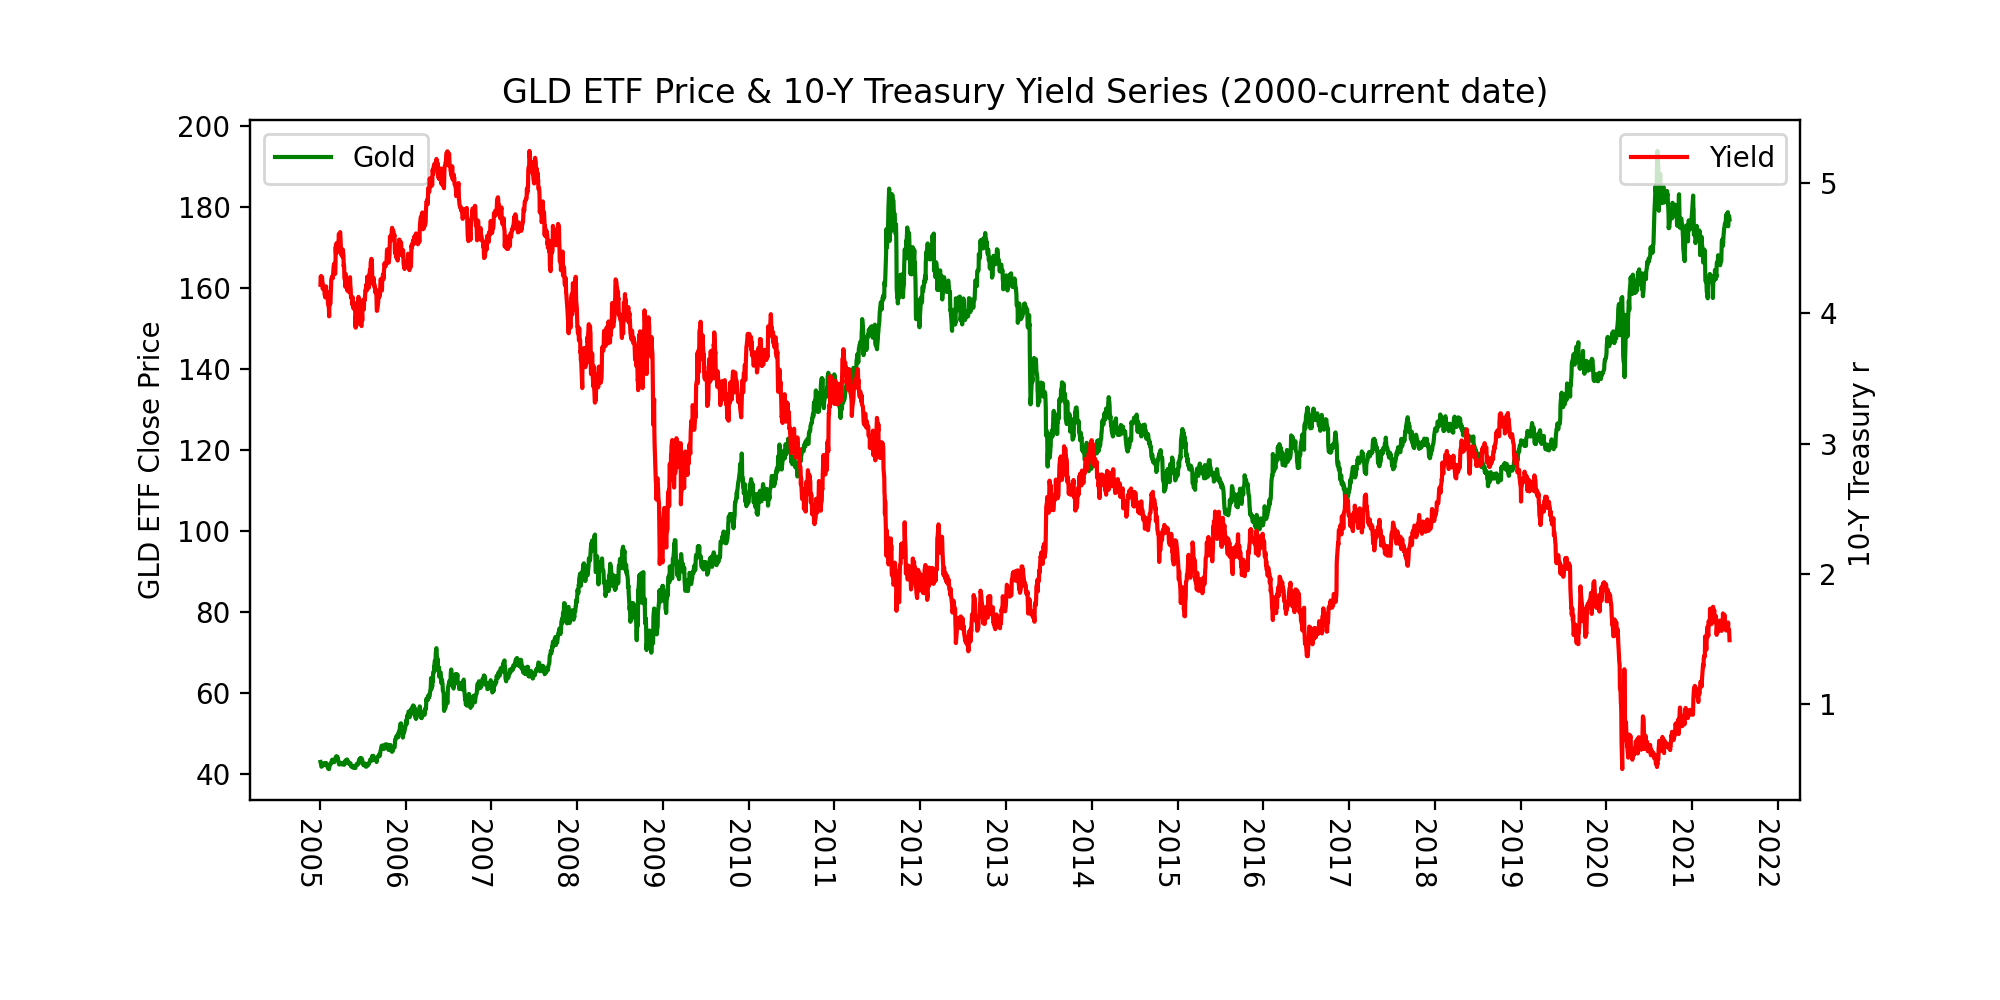

In [3]:
# Plotting a simple graph to check the data

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

fig, ax = plt.subplots()
fig.set_size_inches(10, 5)

ax.set_ylabel("GLD ETF Close Price")
ax.set_title("GLD ETF Price & 10-Y Treasury Yield Series (2000-current date)")
ax.plot('Date', 'Close', data=gold_data, color='g')

ax2 = ax.twinx()
ax2.plot('Date', 'Close', data=treasury_10y_yield_df, color='r')
ax2.set_ylabel("10-Y Treasury r ")

year = mdates.YearLocator()
ax.xaxis.set_major_locator(year)
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
ax.legend(['Gold'])
ax2.legend(['Yield'])
fig.autofmt_xdate(rotation=270)





In [4]:
# Calculating a correlation between yields and gold prices

df_merged = pd.merge(gold_data, treasury_10y_yield_df, on='Date', suffixes = (' Gold', ' Yield'))

df_merged = df_merged.set_index('Date')
df_merged.corr(method='pearson')

# Negative Correlation of -0.86

,Close Gold,Close Yield
Close Gold,1.000000,-0.856146
Close Yield,-0.856146,1.000000


Linear model coeff (w): [-27.35921611]
Linear model intercept (b): 191.122
R-squared score (training): 0.667
R-squared score (test): 0.796
Gold Price = -27.36 * Yield  + 191.12 


<IPython.core.display.Javascript object>


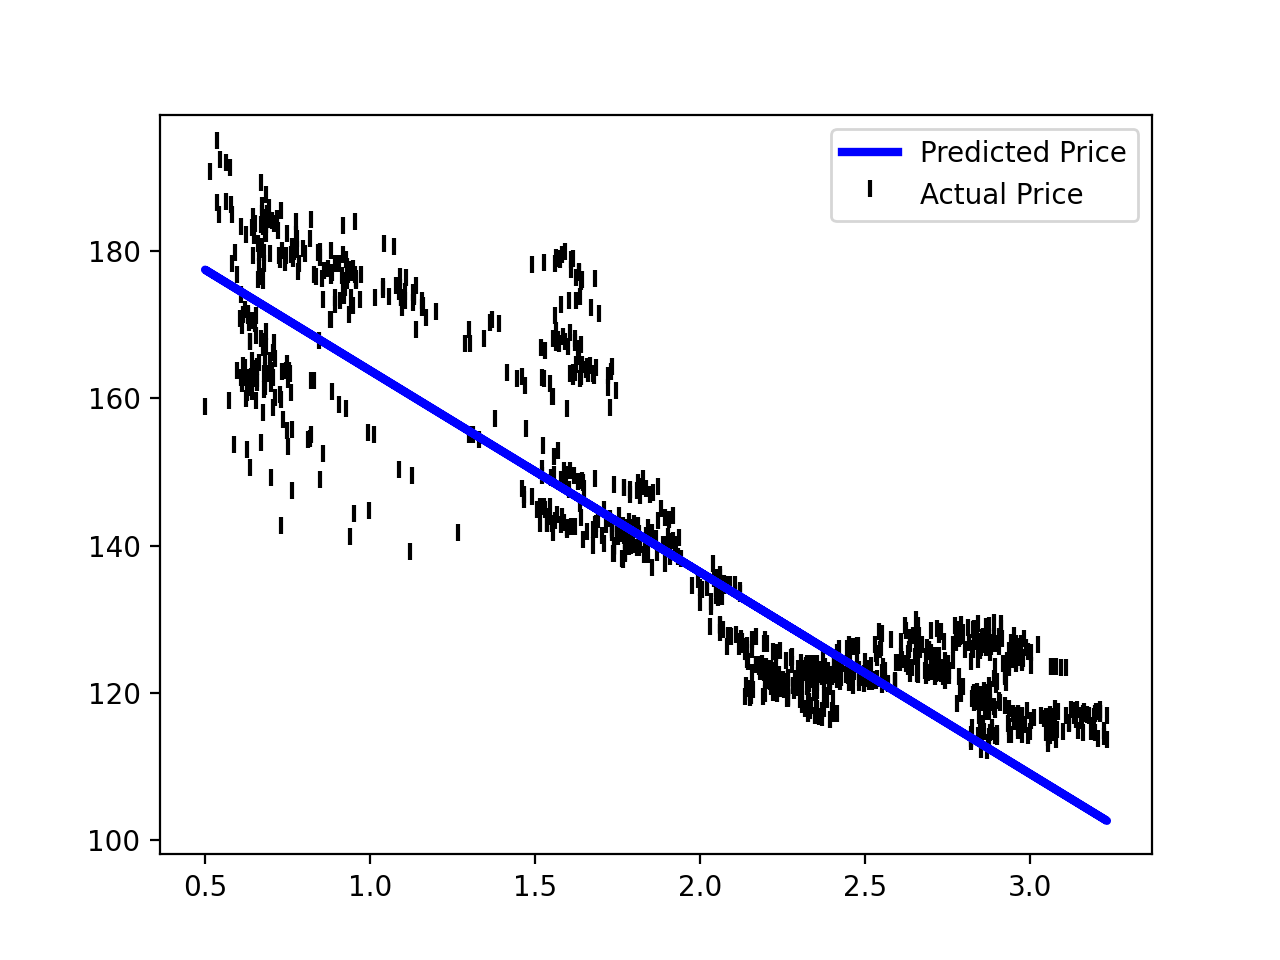

In [5]:
# Linear Regression Model

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split



X = df_merged[['Close Yield']]
y = df_merged['Close Gold']



X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, stratify=None)
linreg =  LinearRegression().fit(X_train, y_train)

predicted_price = linreg.predict(X_test)


print('Linear model coeff (w): {}'
     .format(linreg.coef_))
print('Linear model intercept (b): {:.3f}'
     .format(linreg.intercept_))
print('R-squared score (training): {:.3f}'
     .format(linreg.score(X_train, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linreg.score(X_test, y_test)))
print("Gold Price = %.2f * Yield  \
+ %.2f " % (linreg.coef_[0], linreg.intercept_))


# Plot Data
fig4, ax4 = plt.subplots()
plt.scatter(X_test, y_test, marker=2, color='black')
plt.plot(X_test, predicted_price, color='blue', linewidth=3)

plt.show()

<IPython.core.display.Javascript object>


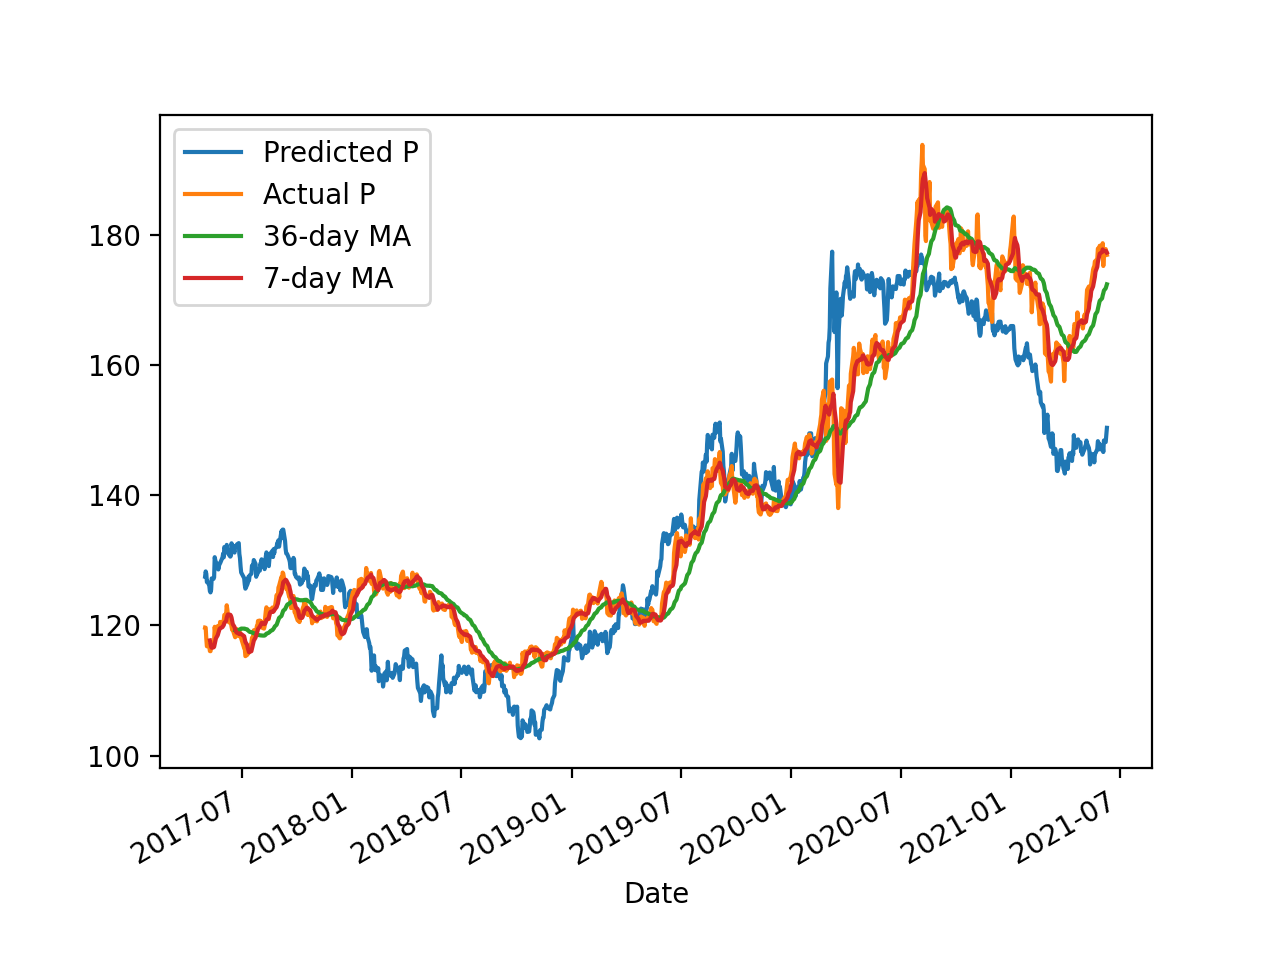

<AxesSubplot:xlabel='Date'>

In [6]:
# Plotting the predicted, actual price
DF_test = pd.DataFrame(index=y_test.index)
DF_test['Predicted P'] = predicted_price
DF_test['Actual P'] = y_test
DF_test['36-day MA'] = y_test.rolling(window=36).mean()
DF_test['7-day MA'] = y_test.rolling(window=7).mean()
plt.legend(['Predicted Price', 'Actual Price', '14-day MA'])

DF_test.plot()


In [7]:
# Backtesting simple long/exit position strategy: 

# A few important details:
# Initial amount = $1000
# Return is calculated assuming cumulative product (one bet = whole account) and the position is made
# exactly at the close price
# This model doesn't include trascations/broker fees costs (they will obviously reduce a return),
# but lets asume we use zero commissions broker.
# Also, this model simplifies the fact that shares cannot be bought with fractions or precisely with our bet amount
# like (e.g $1000 for GLD P=$190 can buy 5.26 shares)

DF1 = pd.DataFrame()
     
t = .75
t = int(t*len(y))
DF1['P'] = y[t:]
DF1['r'] = X[t:]
DF1['Predicted P'] = predicted_price
DF1['Actual P'] = y_test
DF1['Gold %'] = DF1['P'].pct_change().shift(-1)
DF1['Signal'] = np.where(DF1['Predicted P'].shift(1) < DF1['Predicted P'], 1, 0)

# GLD DATA for comparison
importGLD2 = importTickerData("GLD", "2016-04-05")
GLD_DF = importGLD2.importData()
GLD_DF = GLD_DF.set_index('Date')


DF1['GLD %'] = GLD_DF['Close'].pct_change().shift(-1)
DF1['$1000 Benchmark'] = 1000*(DF1['GLD %']+1).cumprod()
 
# Moving Average Slope Signal
DF1['36-day MA'] = y_test.rolling(window=36).mean()
DF1['7-day MA'] = y_test.rolling(window=7).mean()

DF1 = DF1.assign(MA_Slope = lambda x: (DF1['36-day MA'] - DF1['36-day MA'].shift(1))/1)
DF1 = DF1.assign(Slope_Deriv = lambda x: (DF1['MA_Slope'] - DF1['MA_Slope'].shift(1))/1)
DF1['Signal2'] = np.where(DF1['MA_Slope'] > 0, 1, 0) #Positive Slope
DF1['Signal3'] = np.where(DF1['Slope_Deriv'] > 0, 1, 0) #Momentum
DF1['Signal4'] = np.where(DF1['7-day MA'] > DF1['36-day MA'], 1, 0) #MA Crossover

# Strategy Signal Main 
DF1 = DF1.assign(SignalComb = lambda x: DF1['Signal2'] + DF1['Signal3'] + DF1['Signal4'])
DF1['SignalMain'] = np.where(np.logical_or(
                                            np.logical_and(np.greater(DF1.Signal, 0), np.greater(DF1.Signal3, 0)), 
                                            np.logical_and(np.greater(DF1.Signal, 0), np.greater(DF1.Signal4, 0))), 
                                            1, 0)
DF1['SignalFINAL'] = np.where(np.logical_or(np.greater(DF1.SignalComb, 2), np.greater(DF1.SignalMain, 0)), 1, 0)

DF1 = DF1.assign(StrategyGLD = lambda x: x['GLD %']*x['SignalFINAL'])
DF1['$1000 Strategy GLD'] = 1000*(DF1['StrategyGLD']+1).cumprod()

# Equal bet
DF1['Profit Equal $1000 Bet'] = (1000*(DF1['StrategyGLD']+1)-1000)
DF1['Total Profit'] = (DF1['Profit Equal $1000 Bet']).cumsum()
DF1['Account'] = (DF1['Total Profit'])+1000

DF1.tail()


[*********************100%***********************]  1 of 1 completed


,P,r,Predicted P,Actual P,Gold %,Signal,GLD %,$1000 Benchmark,36-day MA,7-day MA,...,Signal3,Signal4,SignalComb,SignalMain,SignalFINAL,StrategyGLD,$1000 Strategy GLD,Profit Equal $1000 Bet,Total Profit,Account
Date,,,,,,,,,,,,,,,,,,,,,
2021-06-03,175.270004,1.625,146.663248,175.270004,0.010783,0,0.010783,1490.999385,171.085834,177.660001,...,0,1,2,0,0,0.000000,1674.412210,0.000000,535.972822,1535.972822
2021-06-04,177.160004,1.560,148.441599,177.160004,0.004008,1,0.004008,1496.974757,171.486945,177.547145,...,1,1,3,1,1,0.004008,1681.122632,4.007628,539.980450,1539.980450
2021-06-07,177.869995,1.569,148.195364,177.869995,-0.003092,0,-0.003092,1492.345995,171.834722,177.580002,...,0,1,2,0,0,-0.000000,1681.122632,0.000000,539.980450,1539.980450
2021-06-08,177.320007,1.528,149.317092,177.320007,-0.001918,1,-0.001918,1489.484417,172.139445,177.524288,...,0,1,2,1,1,-0.001918,1677.899075,-1.917503,538.062947,1538.062947
2021-06-09,176.979996,1.489,150.384103,176.979996,NaN,1,NaN,NaN,172.447500,177.324286,...,1,1,3,1,1,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>


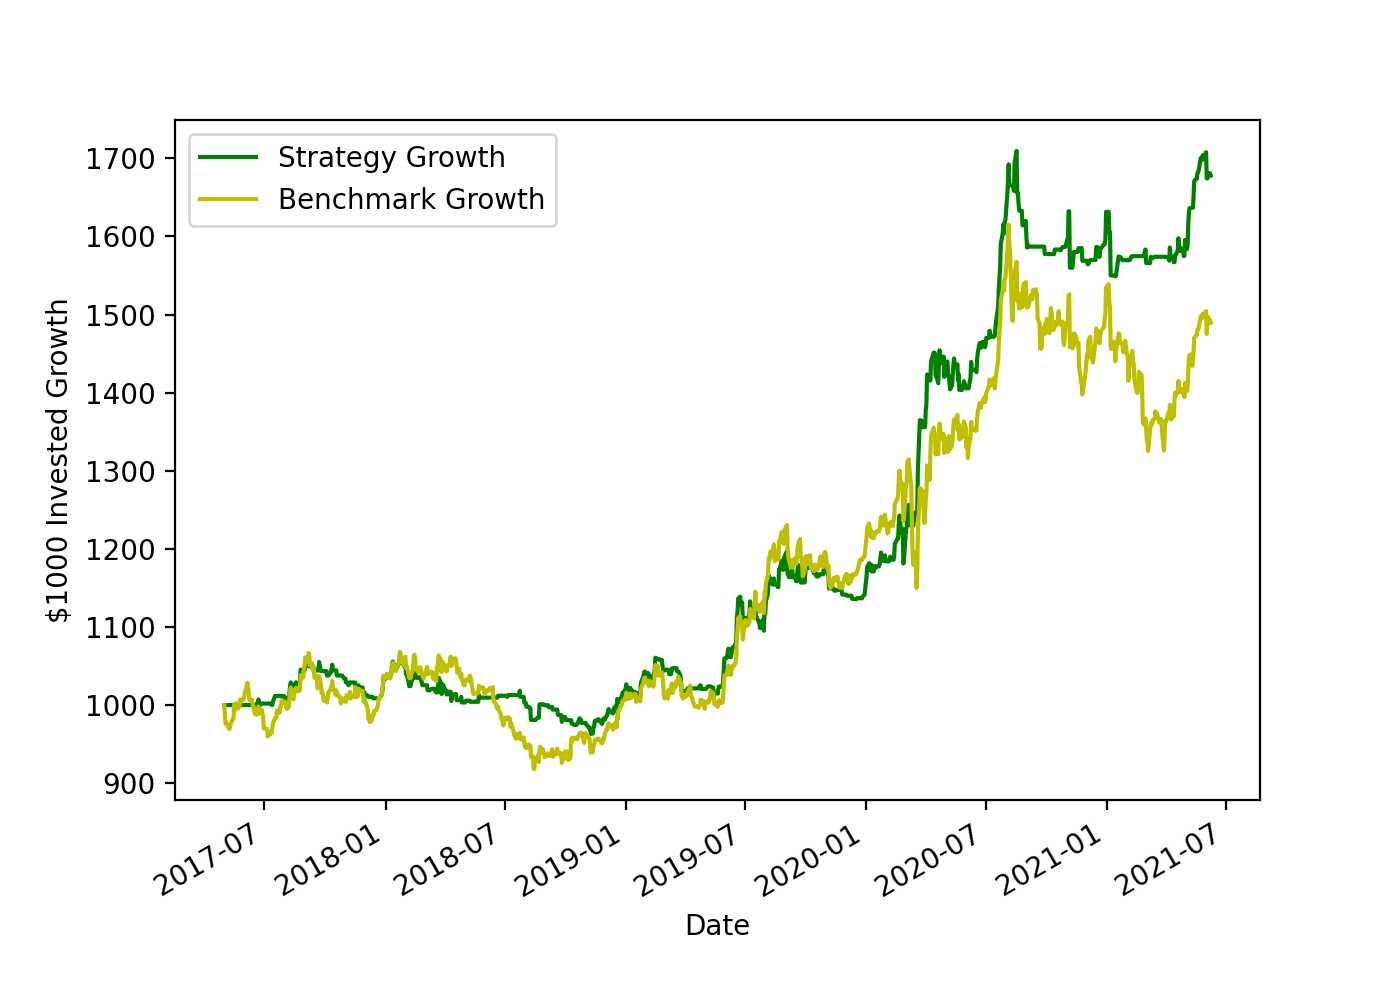

In [8]:
# Plotting returns

fig3, ax3 = plt.subplots()
DF1['$1000 Strategy GLD'].plot(figsize=(7, 5), color='g')
DF1['$1000 Benchmark'].plot(color='y')

plt.ylabel('$1000 Invested Growth')
plt.legend(['Strategy Growth', 'Benchmark Growth'])
plt.show()


In [9]:
# Sharpe Ratio

sharpe = DF1['StrategyGLD'].mean()/DF1['StrategyGLD'].std()*np.sqrt(252)
'Sharpe Ratio %.2f' % (sharpe)

'Sharpe Ratio 1.32'